# Graphical Analysis of GitHub Repositories and Contributors

In this notebook, we programatically view the connections between open source projects, determine project clusters, and map out technology ecosystems. We explore the Augur GitHub data to view relationships between open source projects and communities by studying graphs based on relations such as common contributors and project activities between different GitHub repositories.

## Connect to Augur database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd
import collections
from functools import reduce

import sqlalchemy as salc
import json
import os
import networkx as nx
import matplotlib.pyplot as plt

with open("../../../config.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Get all the Data, Build all the Graphs

In [3]:
# Subset repositories based on a category
# Selecting repositories that fall under the Containers org on Github
def filtered_deps(group_name: str) -> str: 
    science_repo_sql = salc.sql.text(f"""
                     SET SCHEMA 'augur_data';
                        SET SCHEMA 'augur_data';
                        SELECT
                        	A.repo_id,
                        	dep_name,
                        	dep_count 
                        FROM
                        	(
                        	SELECT
                        		augur_data.repo_dependencies.dep_name,
                        		augur_data.repo_dependencies.repo_id,
                        		dep_count, 
								max(data_collection_date) 
                        	FROM
                        		augur_data.repo_dependencies 
                        	GROUP BY
                        		augur_data.repo_dependencies.dep_name,
                        		augur_data.repo_dependencies.repo_id, 
								augur_data.repo_dependencies.dep_count 
                        	ORDER BY
                        		dep_count DESC 
                        	) A, 
                             (                    	
                                SELECT C.repo_id
                                FROM
                                    augur_operations.users A,
                                    augur_operations.user_groups b,
                                    augur_operations.user_repos C
                                WHERE
                                    A.user_id = b.user_id 
                                    AND b.group_id = C.group_id 
                                    AND b.NAME = \'{group_name}\'
                                ORDER BY
                                    A.login_name,
                                    b.group_id 
                                ) b 
                            WHERE
                                A.repo_id = b.repo_id
								order by dep_count desc;                 
                """)
    
    with engine.connect() as conn:
        #df = pd.read_sql(sql, cnxn)
        results = conn.execute(science_repo_sql)
        df_results = pd.DataFrame(results) 
    
    print(df_results)
    return df_results

    

## Dependencies

In [14]:
deps_df = pd.DataFrame()

deps_df = filtered_deps('science')

display(deps_df)

deps_df = deps_df[deps_df.dep_count>=20]
display(deps_df)

df_deps = deps_df.groupby(['repo_id', 'dep_name']).size().unstack(fill_value=0)


display(deps_df)
display(df_deps)
deps_df.dtypes
df_deps.dtypes

df_deps = df_deps.reset_index()
display(df_deps)
display(df_deps.dtypes) 

display(df_deps.dtypes) 
display(df_deps)

df_melted_deps = df_deps.melt(
    ['repo_id'],
     var_name='dep_name', value_name='dep_count') 

display(df_melted_deps)


       repo_id                          dep_name  dep_count
0        26317                                         1237
1        29182                              Node       1140
2        29182                                         1045
3        27818                                          802
4        29182                               ant        760
...        ...                               ...        ...
17355    29538                                os          1
17356    29453               flask_dance_storage          1
17357    25557  repo2docker.contentproviders.doi          1
17358    29334                          jsonlint          1
17359    29428                                            1

[17360 rows x 3 columns]


,repo_id,dep_name,dep_count
0,26317,,1237
1,29182,Node,1140
2,29182,,1045
3,27818,,802
4,29182,ant,760
...,...,...,...
17355,29538,os,1
17356,29453,flask_dance_storage,1
17357,25557,repo2docker.contentproviders.doi,1
17358,29334,jsonlint,1


,repo_id,dep_name,dep_count
0,26317,,1237
1,29182,Node,1140
2,29182,,1045
3,27818,,802
4,29182,ant,760
...,...,...,...
530,27988,django.conf,20
531,29144,ant,20
532,27133,globus_sdk,20
533,29205,pandas,20


,repo_id,dep_name,dep_count
0,26317,,1237
1,29182,Node,1140
2,29182,,1045
3,27818,,802
4,29182,ant,760
...,...,...,...
530,27988,django.conf,20
531,29144,ant,20
532,27133,globus_sdk,20
533,29205,pandas,20


dep_name,,../../abstract_unit,../abstract_unit,../helper,ActionTypes,Bolt,Classes,CssString,DataDog,DataverseAPILink,...,utils,uuid,v1,v1alpha2,v3,v4,vector,vetiver,web,window
repo_id,,,,,,,,,,,,,,,,,,,,,
25531,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
25556,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25582,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


dep_name,repo_id,,../../abstract_unit,../abstract_unit,../helper,ActionTypes,Bolt,Classes,CssString,DataDog,...,utils,uuid,v1,v1alpha2,v3,v4,vector,vetiver,web,window
0,25531,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,25556,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,25557,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,25569,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,25582,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,31010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,31231,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,31301,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,32043,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


dep_name
repo_id                int64
                       int64
../../abstract_unit    int64
../abstract_unit       int64
../helper              int64
                       ...  
v4                     int64
vector                 int64
vetiver                int64
web                    int64
window                 int64
Length: 257, dtype: object

dep_name
repo_id                int64
                       int64
../../abstract_unit    int64
../abstract_unit       int64
../helper              int64
                       ...  
v4                     int64
vector                 int64
vetiver                int64
web                    int64
window                 int64
Length: 257, dtype: object

dep_name,repo_id,,../../abstract_unit,../abstract_unit,../helper,ActionTypes,Bolt,Classes,CssString,DataDog,...,utils,uuid,v1,v1alpha2,v3,v4,vector,vetiver,web,window
0,25531,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,25556,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,25557,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,25569,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,25582,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,31010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,31231,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,31301,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,32043,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,repo_id,dep_name,dep_count
0,25531,,1
1,25556,,0
2,25557,,0
3,25569,,0
4,25582,,1
...,...,...,...
27899,31010,window,0
27900,31231,window,0
27901,31301,window,0
27902,32043,window,0


,repo_id,dep_name,dep_count
204,29985,../../abstract_unit,1
313,29985,../abstract_unit,1
422,29985,../helper,1
467,26317,ActionTypes,1
553,25607,Bolt,1
...,...,...,...
27519,28424,vector,1
27553,29741,vector,1
27655,29621,vetiver,1
27699,25638,web,1


None

None

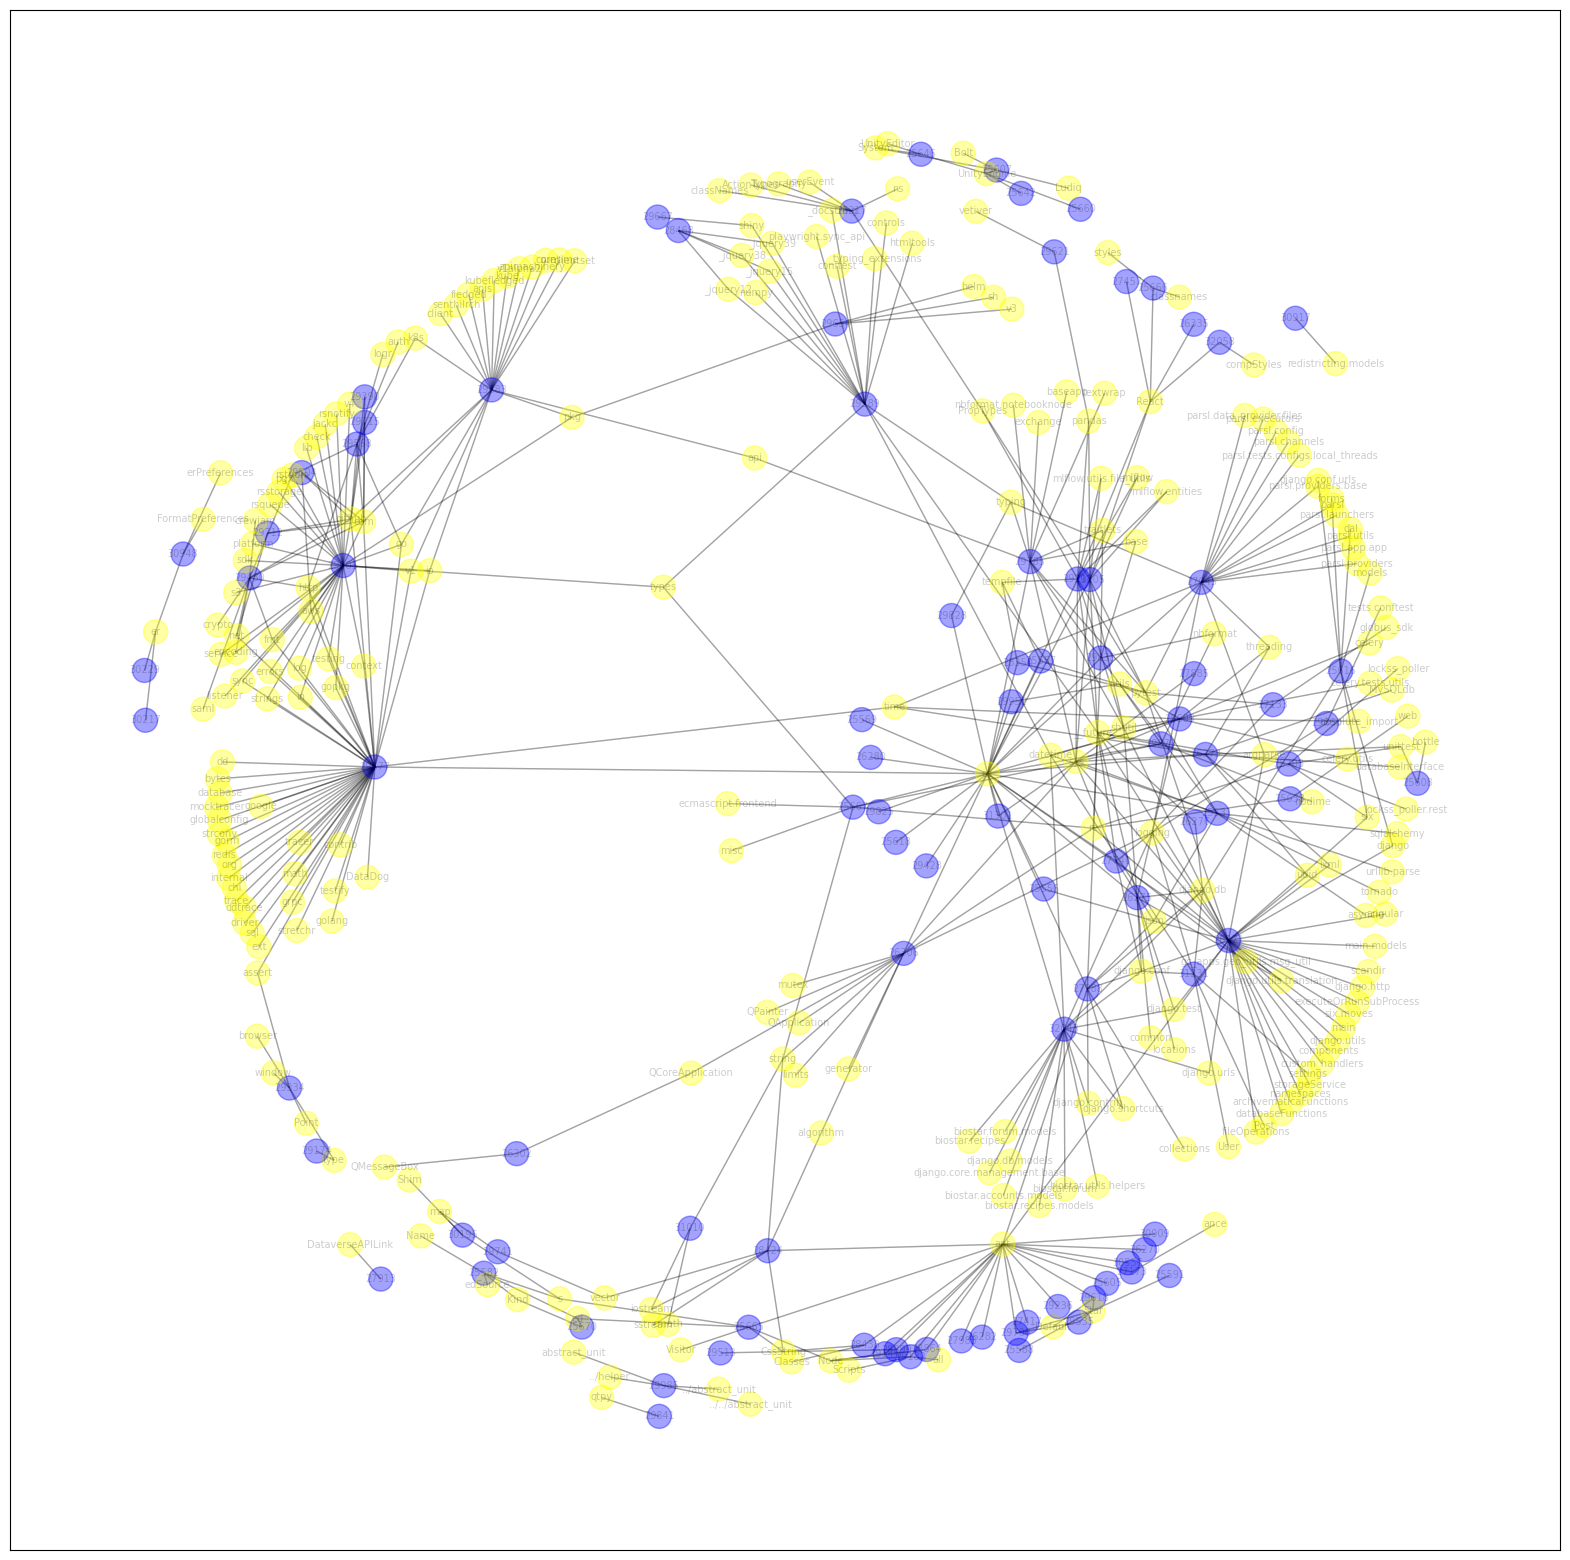

In [17]:
df_melted_deps = df_melted_deps[df_melted_deps[df_melted_deps.columns[2]] != 0]
df_melted_deps = df_melted_deps[df_melted_deps[df_melted_deps.columns[1]] != '']

display(df_melted_deps)
repo_id = df_melted_deps['repo_id'].to_list()
dep_name = df_melted_deps['dep_name'].to_list()
G = nx.from_pandas_edgelist(df_melted_deps, 
                            source='dep_name',
                            target='repo_id',
                            create_using=nx.MultiGraph())

nodes = G.nodes()
#display(nodes)
colors = ['blue' if n in repo_id else 'yellow' for n in nodes]


repo_id = df_melted_deps['repo_id'].to_list()
dep_name = df_melted_deps['dep_name'].to_list()
#colors = ['red' if nodes in repo_id else 'yellow']
#node_size = [depcount if n in dep_name else 120 if n in nodes]

fig, ax = plt.subplots(figsize=(20,20))
pos = nx.fruchterman_reingold_layout(G)
spos = nx.spring_layout(G, pos=pos, k=.4)

labelgraph = nx.draw_networkx(G, with_labels=False, node_color=colors, pos=spos, alpha=0.2, font_size=7, ax=ax)
anonygraph = nx.draw_networkx(G, node_color=colors, pos=spos, alpha=0.2, font_size=7, ax=ax)

display(labelgraph)
display(anonygraph)